# Measurements Reindexing Mainnet

These measurements were made on a full node on GCP (Google Compute) reindexing mainnet.

The host is type `n1-standard-1` which means:
 * 1 virtual CPU (pinned to the host CPU)
 * 4096 MB of RAM, of which about 3.6 GB is available to userspace
 * Very slow disks (connected to some kind of SAN)
 
Bitcoin itself is configured with `dbcache=2048`.

## Motivation

The motivation here is to make IBD work better on machines with slow disks. For instance, on most cloud instances IBD will be extremely I/O bound, to the point that it's basically impossible to actually finish syncing a node. This is true even on hosts that have a relatively large amount of memory, and therefore ought to be able ot keep most of the dataset in memory.

## A Priori Memory Predictions

How much memory would we expect the UTXO set to use if it was fully loaded into memory? We can calculate this with the size of keys/values and the number of entries in the UTXO set.

Even on hosts that don't have this much memory for their dbcache, hosts that have a reasonable proportion of that memory (e.g. 50% of it) ought to see a big speedup.

In [1]:
coutpoint_size = 36  # sizeof(COutPoint)
cache_entry_size = 56  # sizeof(CCoinsCacheEntry)
current_utxo_size = 57.3e6  # approximate number of entries in the current uxto set
estimated_map_size = (coutpoint_size + cache_entry_size) * current_utxo_size
print('Estimated memory: {:1.2f} GB'.format(estimated_map_size / (1<<30)))

Estimated memory: 4.91 GB


Note that this estimate assumes no overhead for the space taken by the hash table itself. Therefore we should consider it a lower bound on the amount of memory that would be needed. Given a properly tuned hash table though the real world results shouldn't take that much more memory.

## Measurements

In [2]:
%matplotlib inline

import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.dpi']= 300
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [10]:
# this loads the local file unpack.py, force reloading it if necessary
import importlib
import sys
try:
    unpack = sys.modules['unpack']
    importlib.reload(unpack)
except KeyError:
    import unpack

# load the data and print some information about it
data = unpack.unpack_data()
frames = data['frames']

print()
print('Host Info')
print('---------')
for k, v in data['hostinfo'].items():
    print('{:16s}{}'.format(k, v))

print()
print('Data Frames')
print('-----------')
print(' '.join(sorted(frames.keys())))

globals().update(frames)

Loading data from input file /home/evan/logs/bitcoin-1518996859.log

Host Info
---------
date            2018-02-18T23:34:19+00:00
hostname        bitcoin
uname           4.14.18-300.fc27.x86_64
memtotal:bytes  20896100352
fdlimit:count   4096
git:commit      89861173caff8c19700c7a844a8c70750345917a
git:branch      leveldb_tweaks

Data Frames
-----------
bio cache flushes leveldb memory updatetip vfs


In [4]:
# List of all flush events that happened
flushes

,count:bytes,count:coins
2018-02-18 15:10:07.604835,761427872,5389943
2018-02-18 15:11:29.578481,761702064,5457786
2018-02-18 15:13:10.225941,761859056,5460140
2018-02-18 15:15:16.532331,761428112,5456536
2018-02-18 15:18:48.629317,763549488,5472589


In [5]:
def plot(df, color='k', title=None, show_flush=True):
    """Generate a plot from a datafame, with flushes overlaid."""
    plt.figure()
    df.plot(title=title)
    if show_flush:
        for t in flushes.index:
            plt.axvline(x=t, color=color, linestyle=':')

### Indexing Rate (Height)

In this section we'll look at how fast the chain is syncing, measured by the chain height.

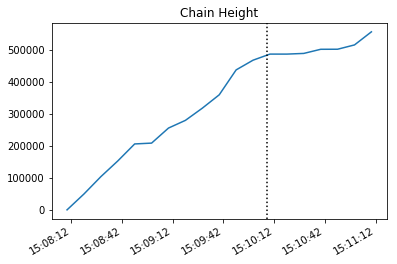

In [19]:
plot(updatetip['height'], title='Chain Height')

In [20]:
if False:
    times = np.array(update_tip.index.to_series())
    front = times[:-1]
    back = times[1:]
    ns_per_block = back - front
    blocks_per_s = (1e9/ns_per_block.astype(int))
    df = pd.DataFrame({'blocks_per_second': blocks_per_s}, index=back)
    plot(df.rolling(10).mean(), title='Blocks Indexed Per Second')

### Indexing Rate (via "Progress" estimate)

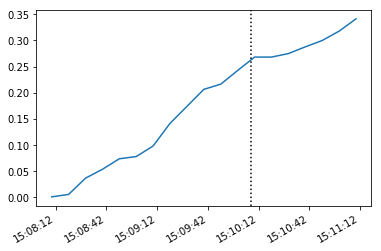

In [21]:
plot(updatetip['progress'] / 1e6)

### Cache Hits

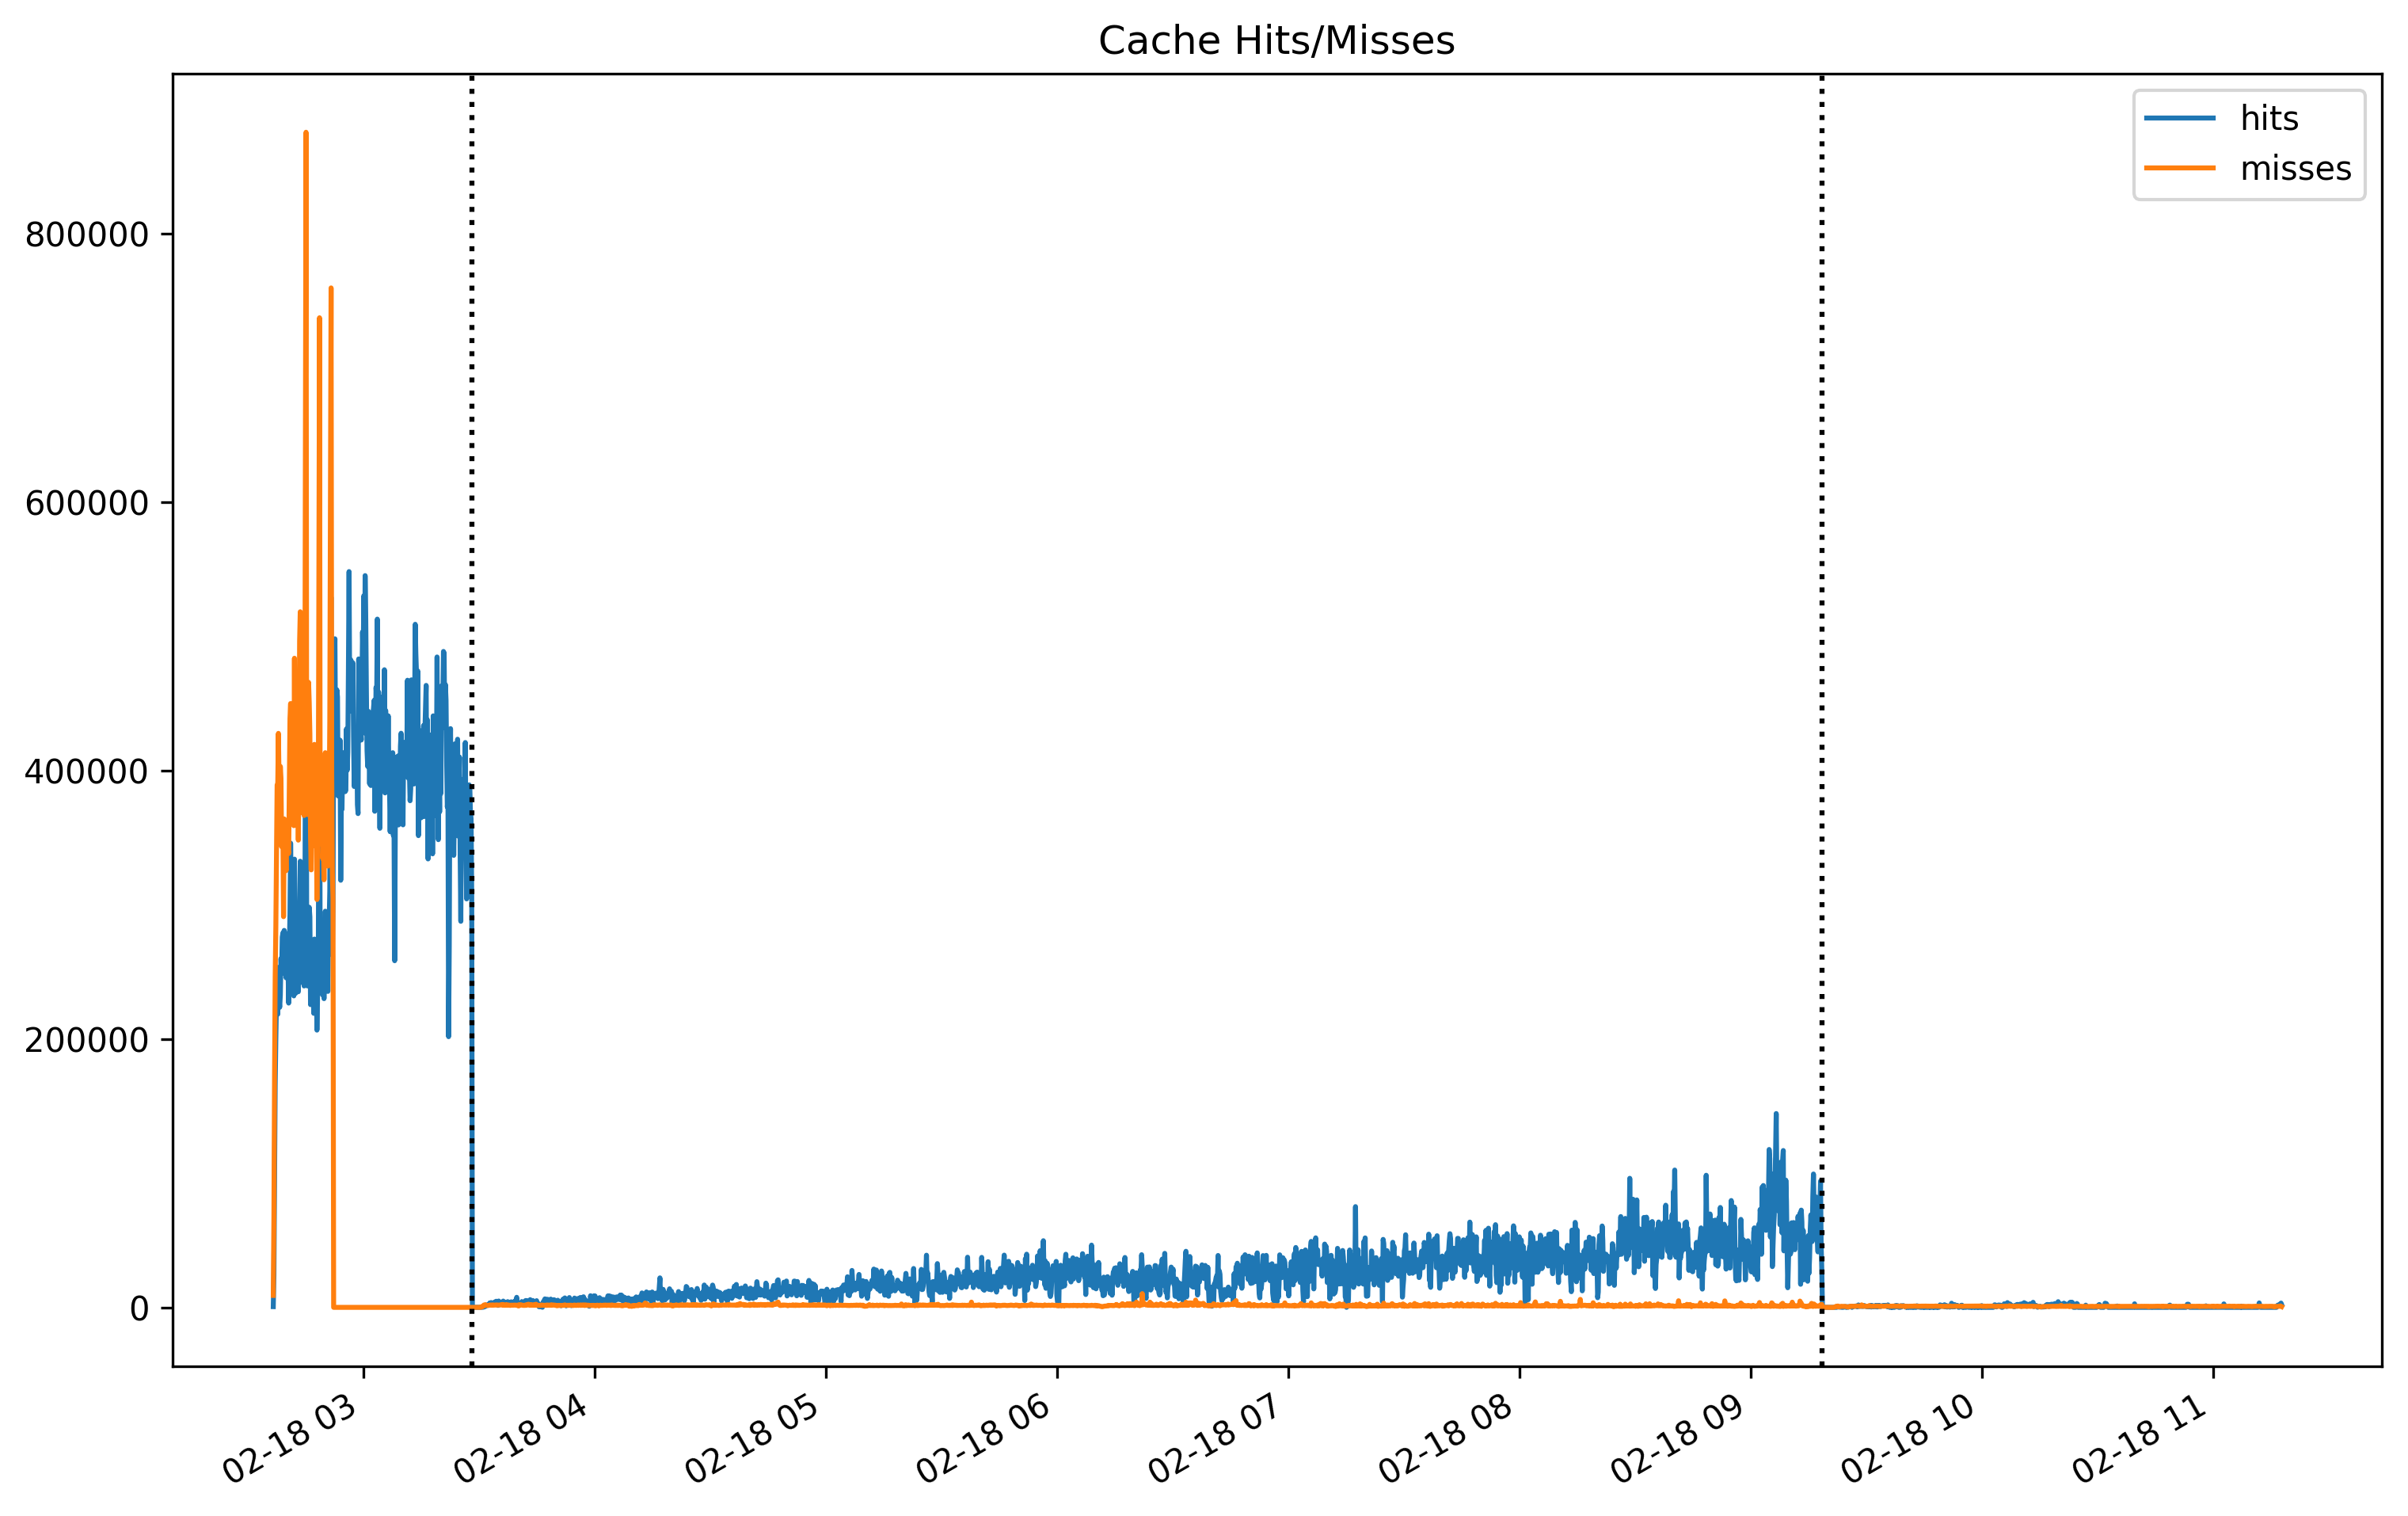

In [30]:
plot(cache, title='Cache Hits/Misses')

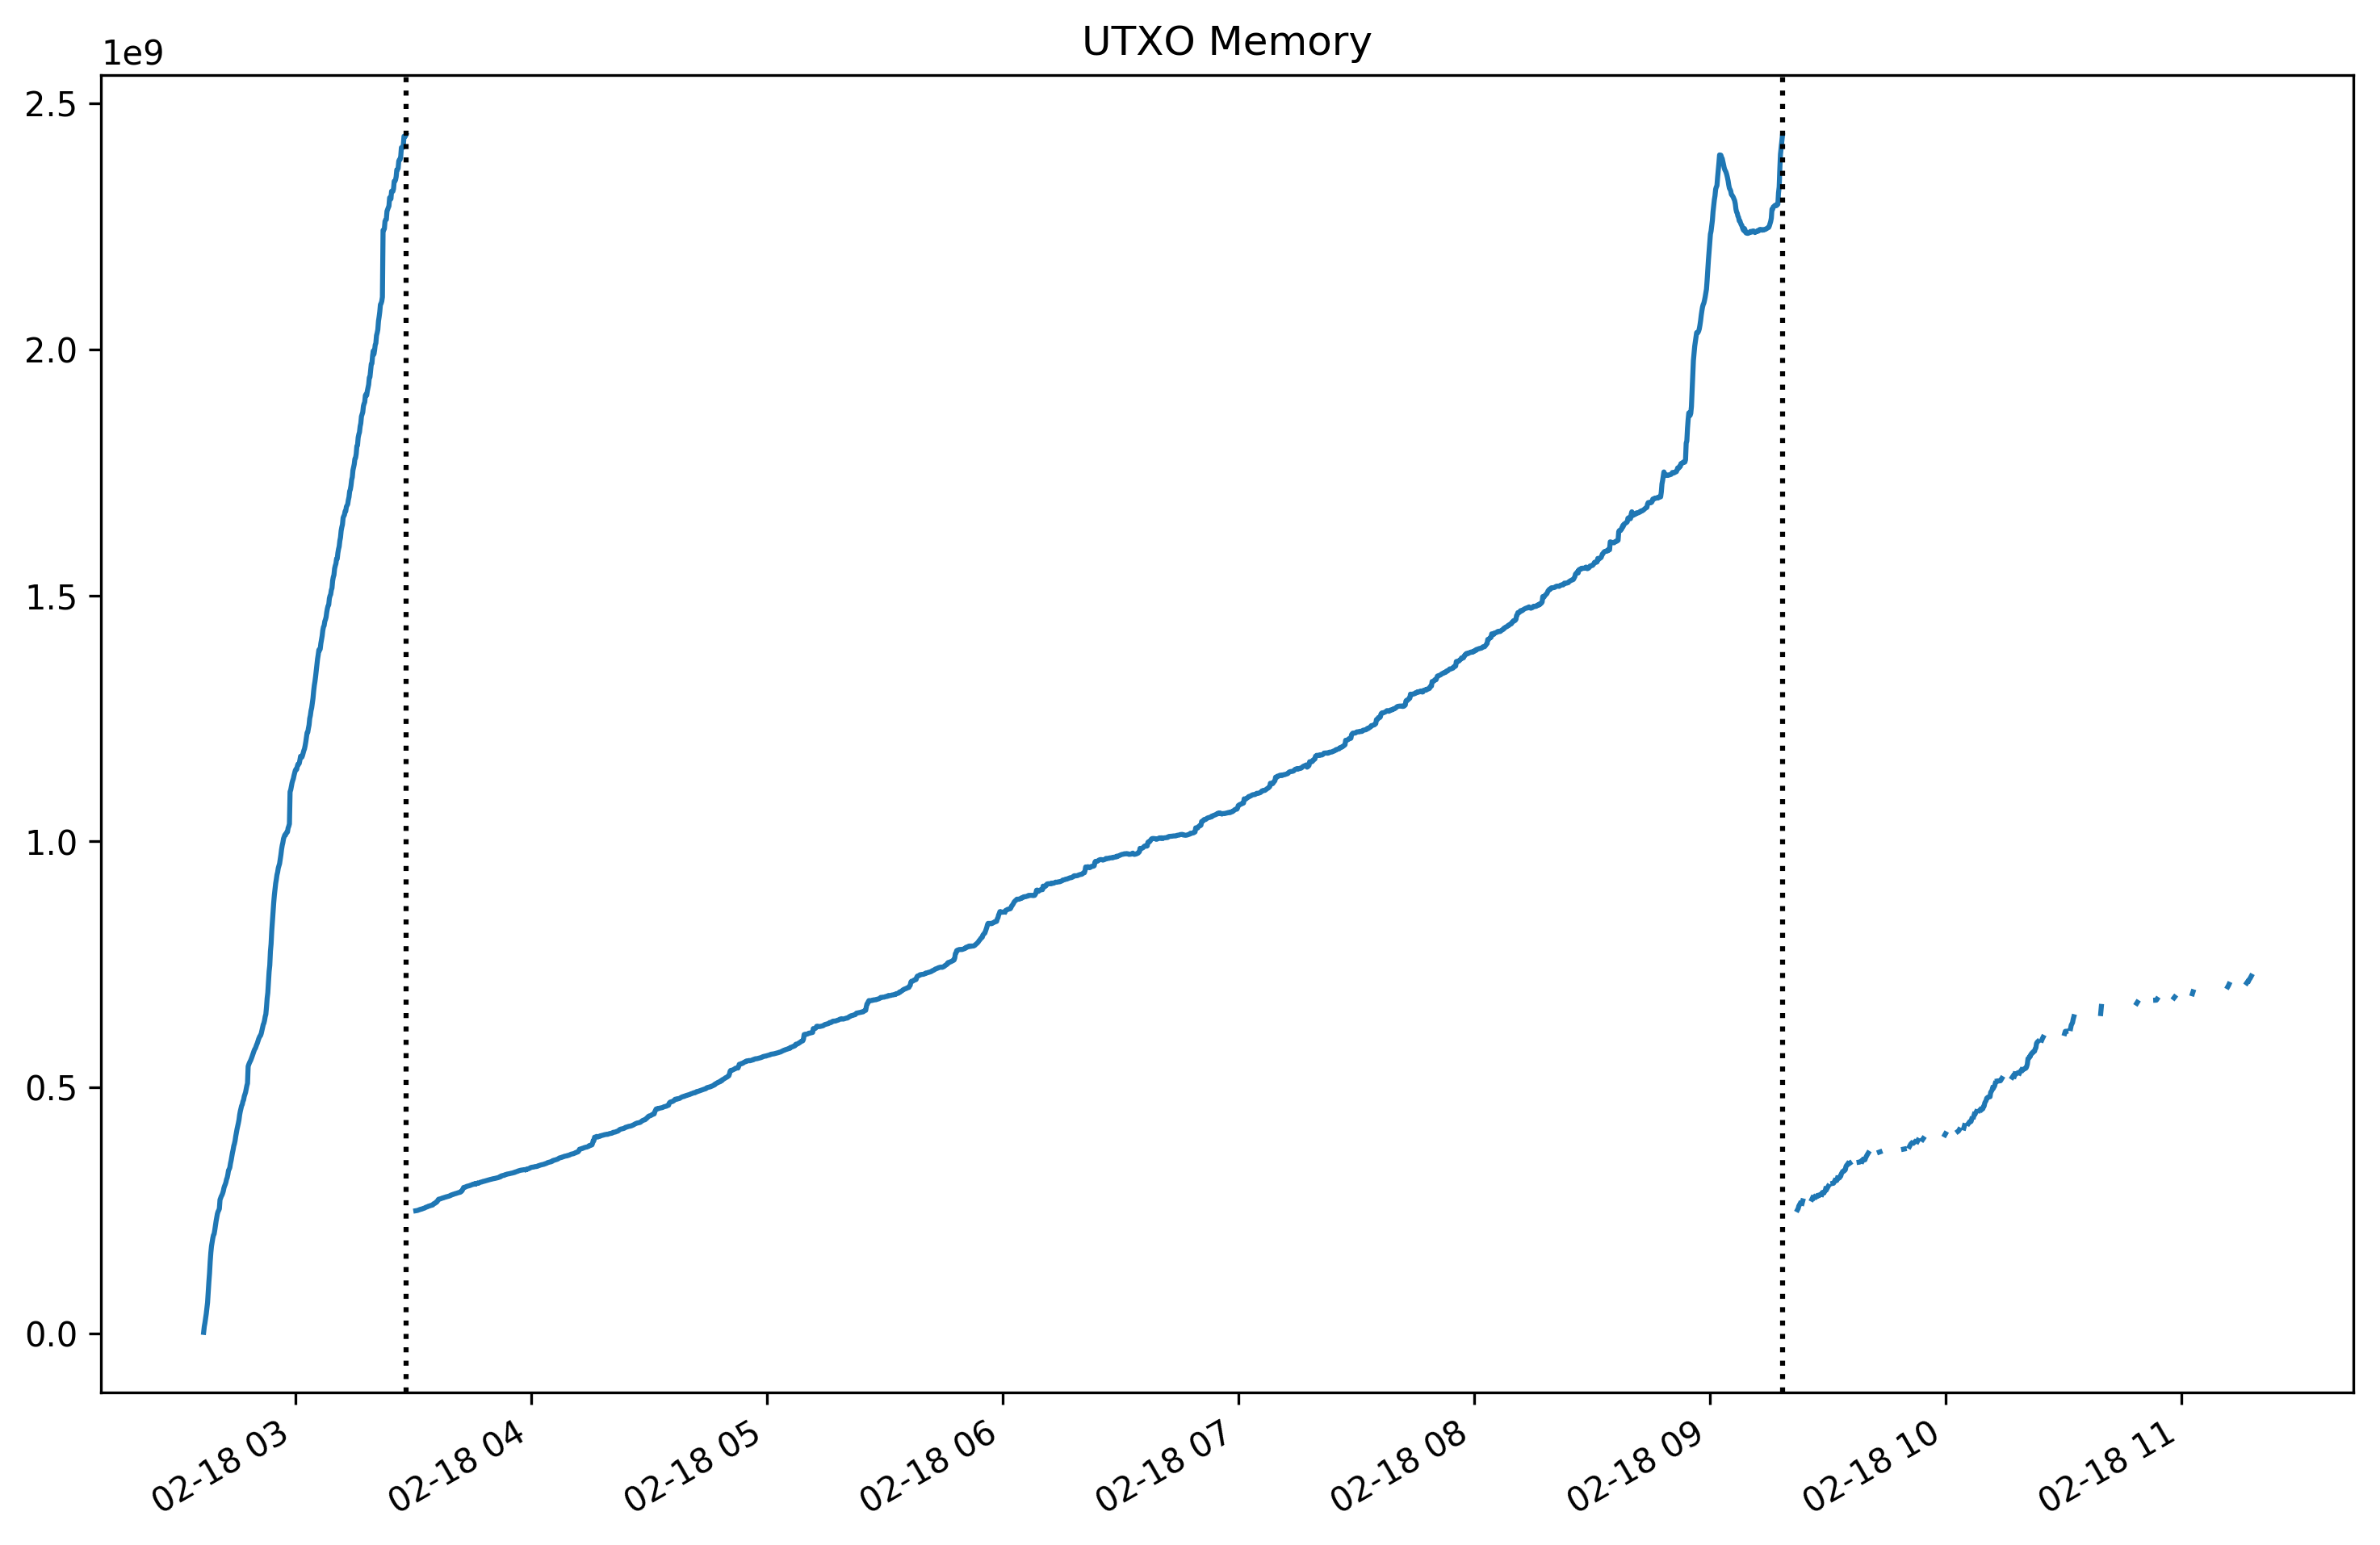

In [31]:
plot(updatetip['memory:utxo'], title='UTXO Memory')

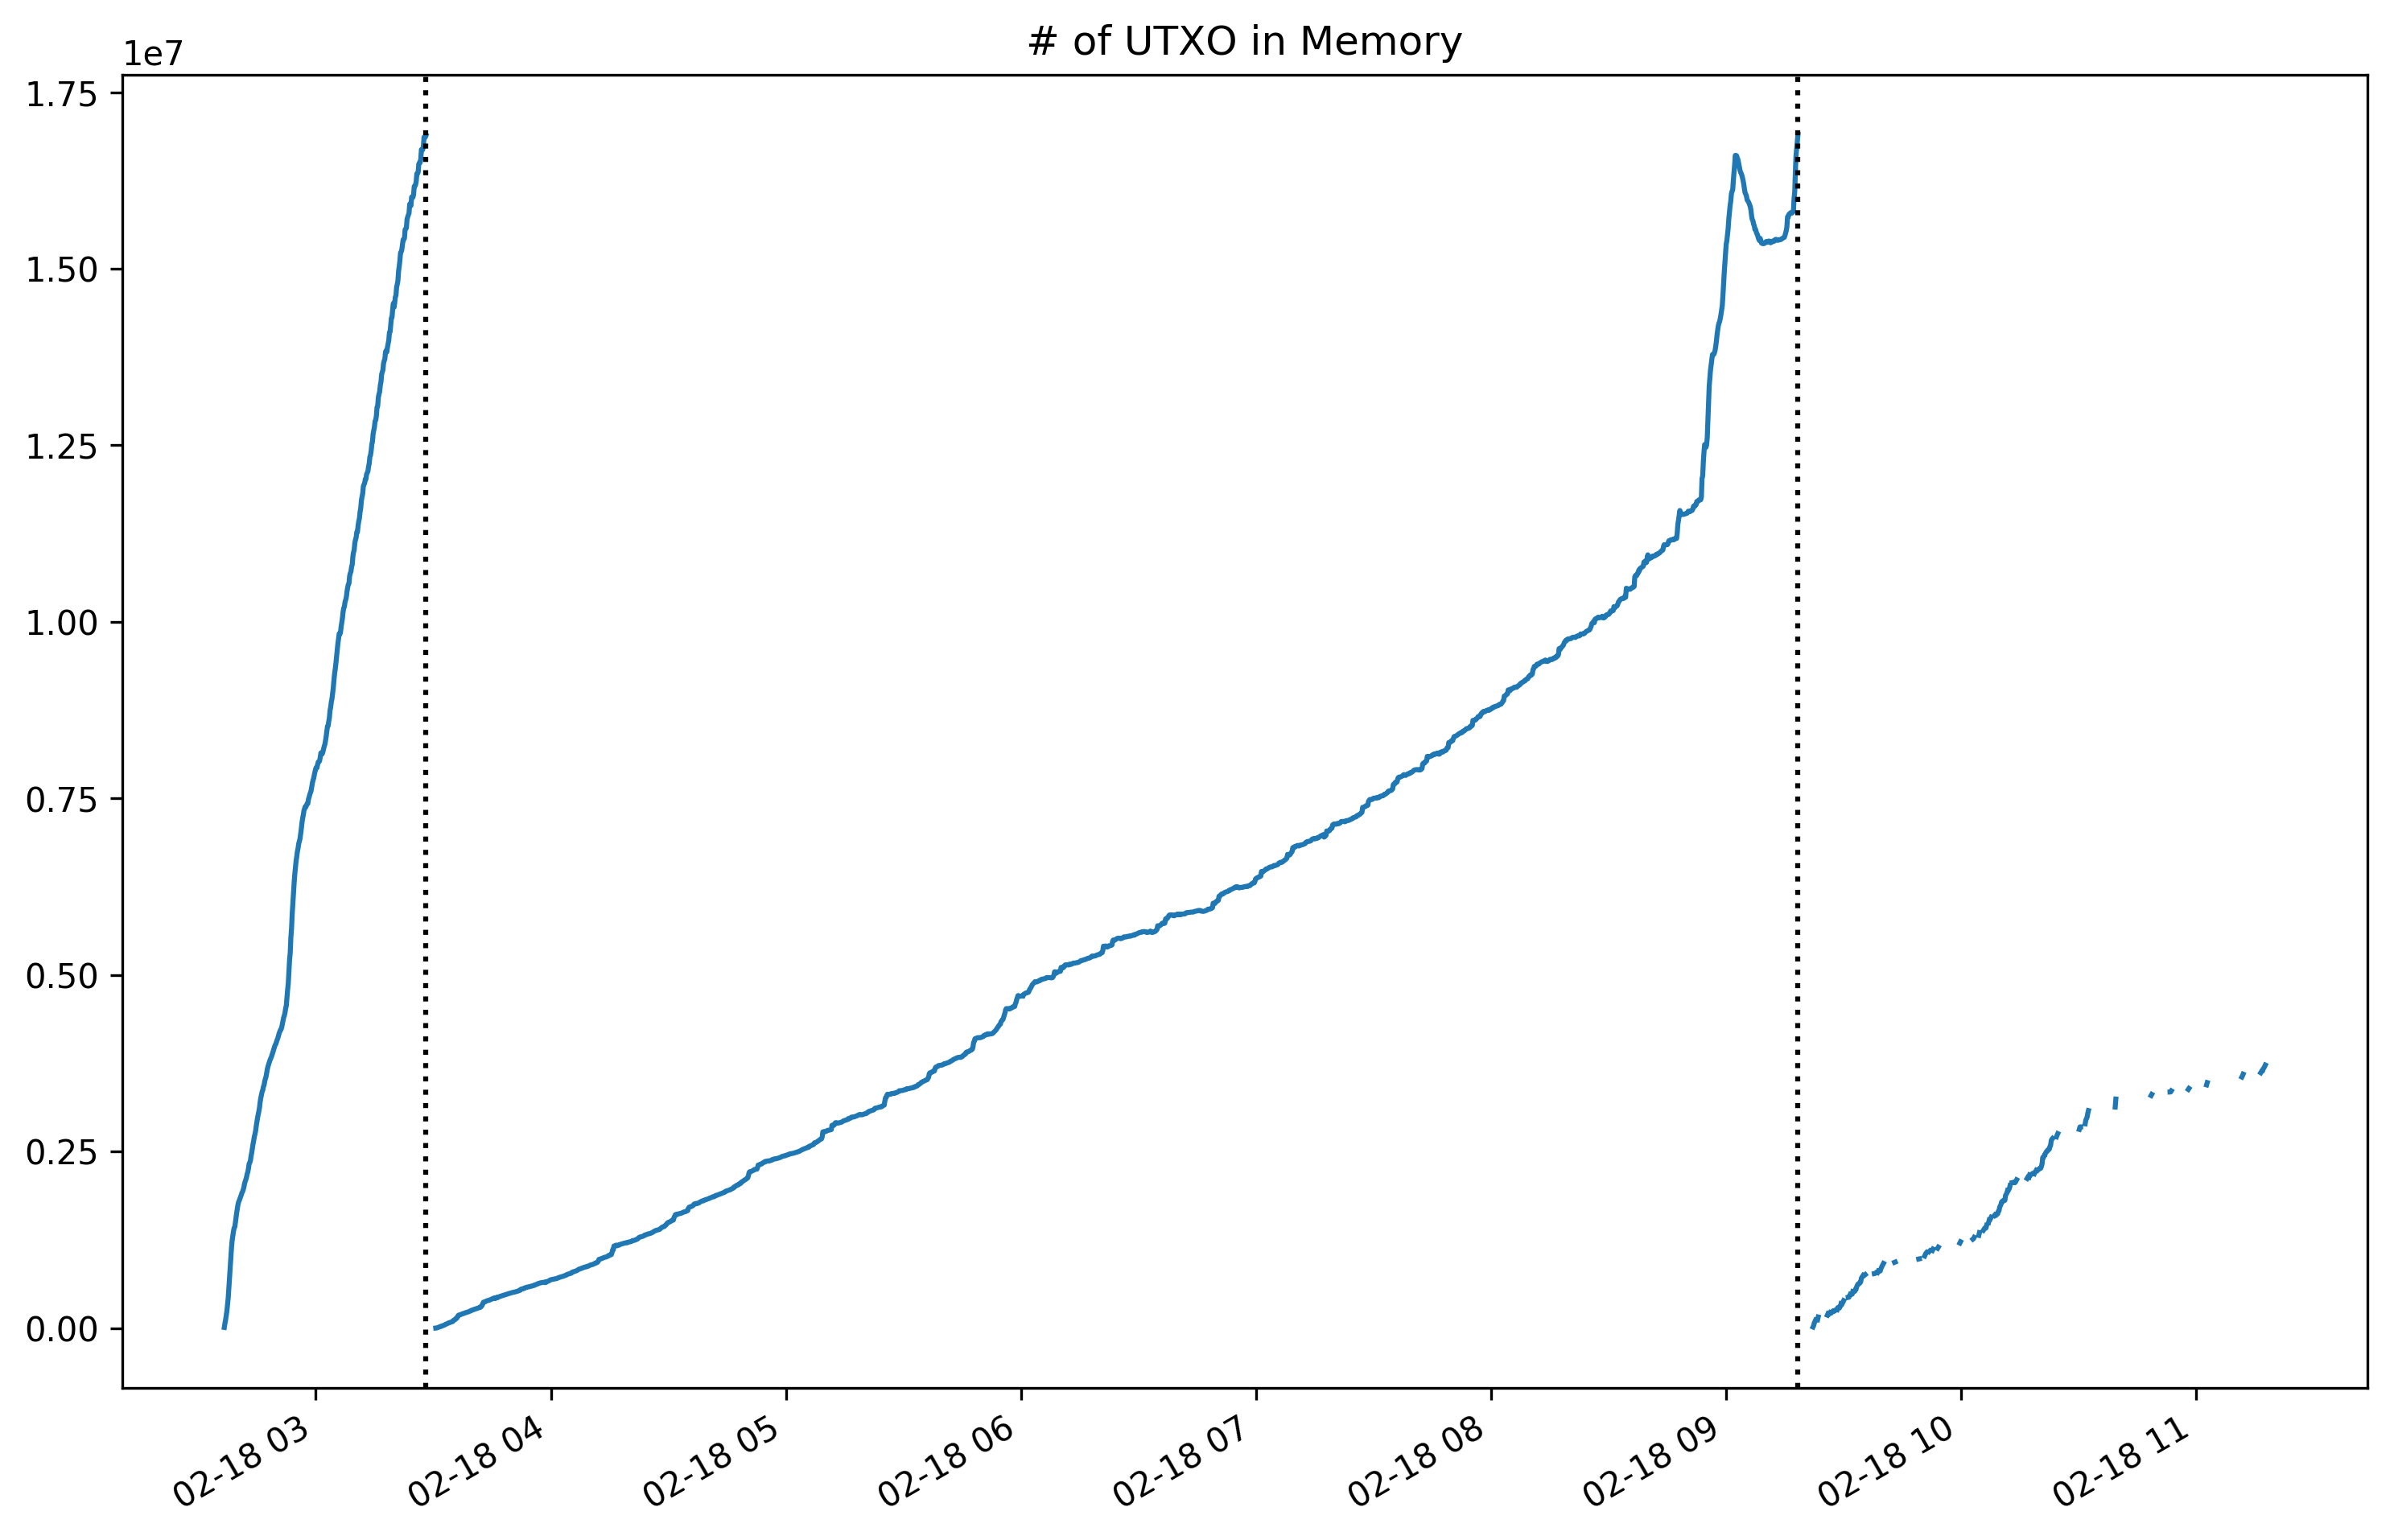

In [32]:
plot(updatetip['count:utxo'], title='# of UTXO in Memory')

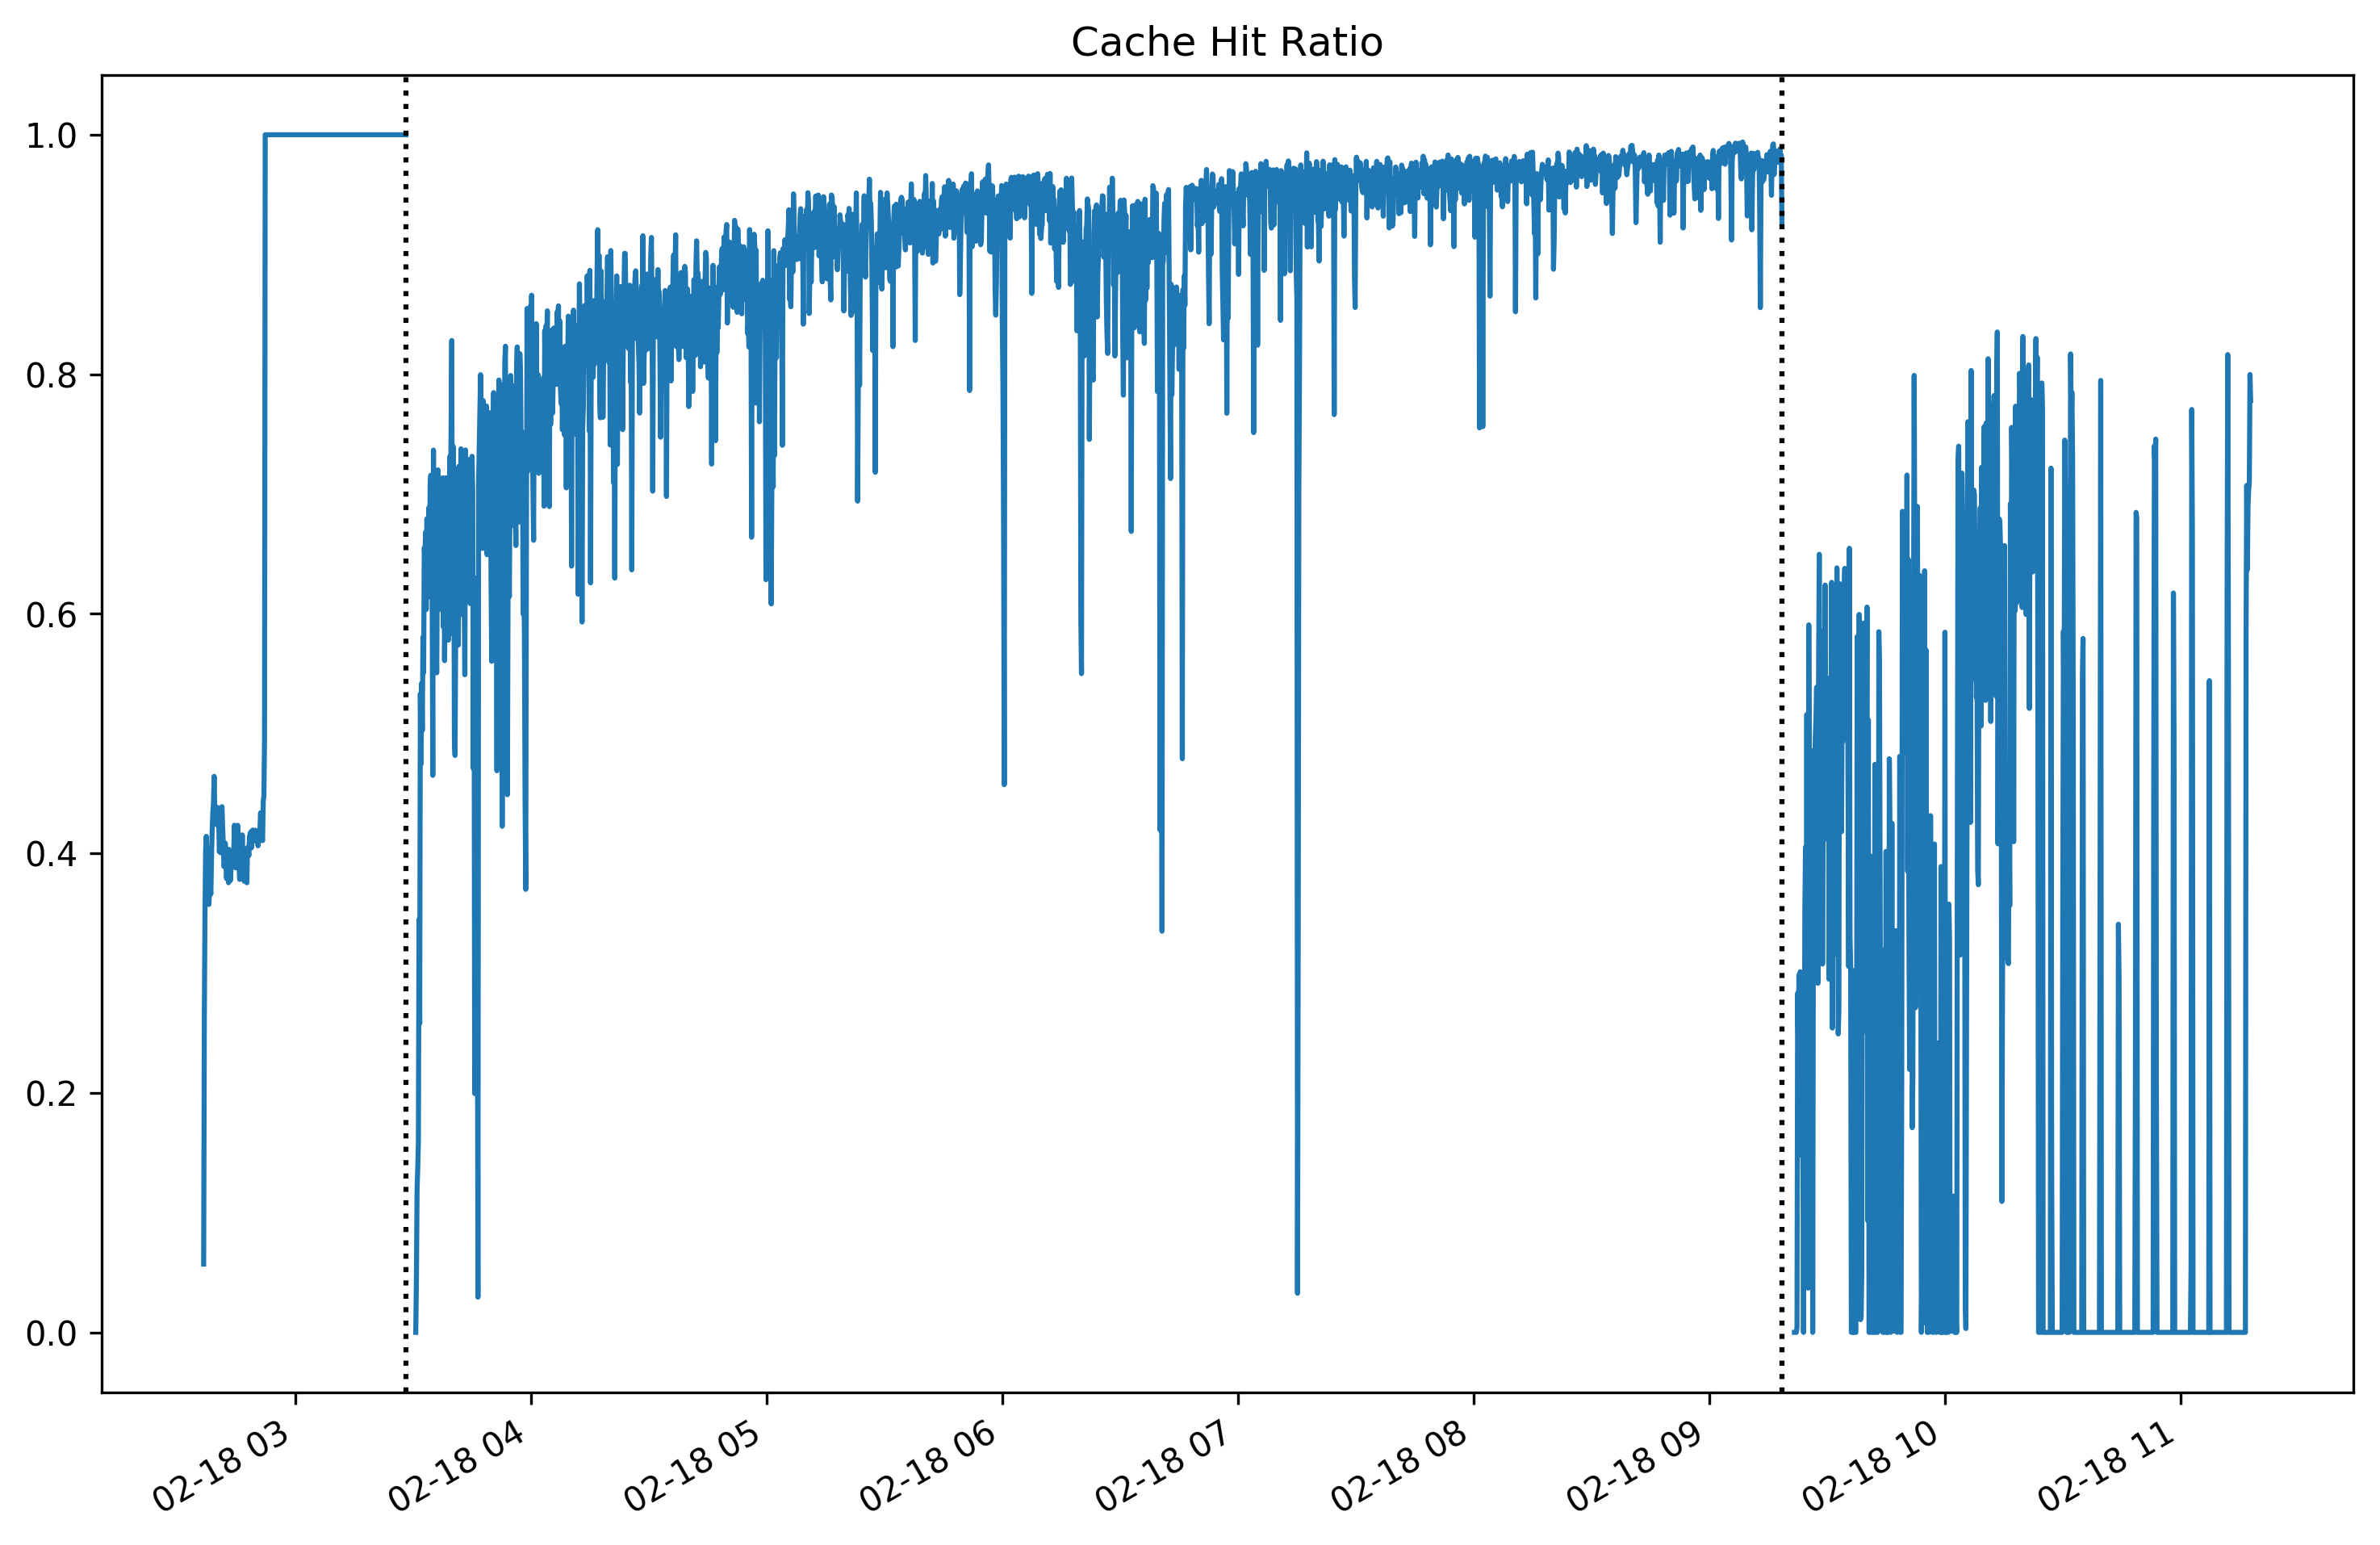

In [33]:
hits = cache['hits']
total = hits + cache['misses']
plot(hits / total, title='Cache Hit Ratio')

In [34]:
sum(hits/sum(total))

0.8111235133175879

## Disk / VFS Stats

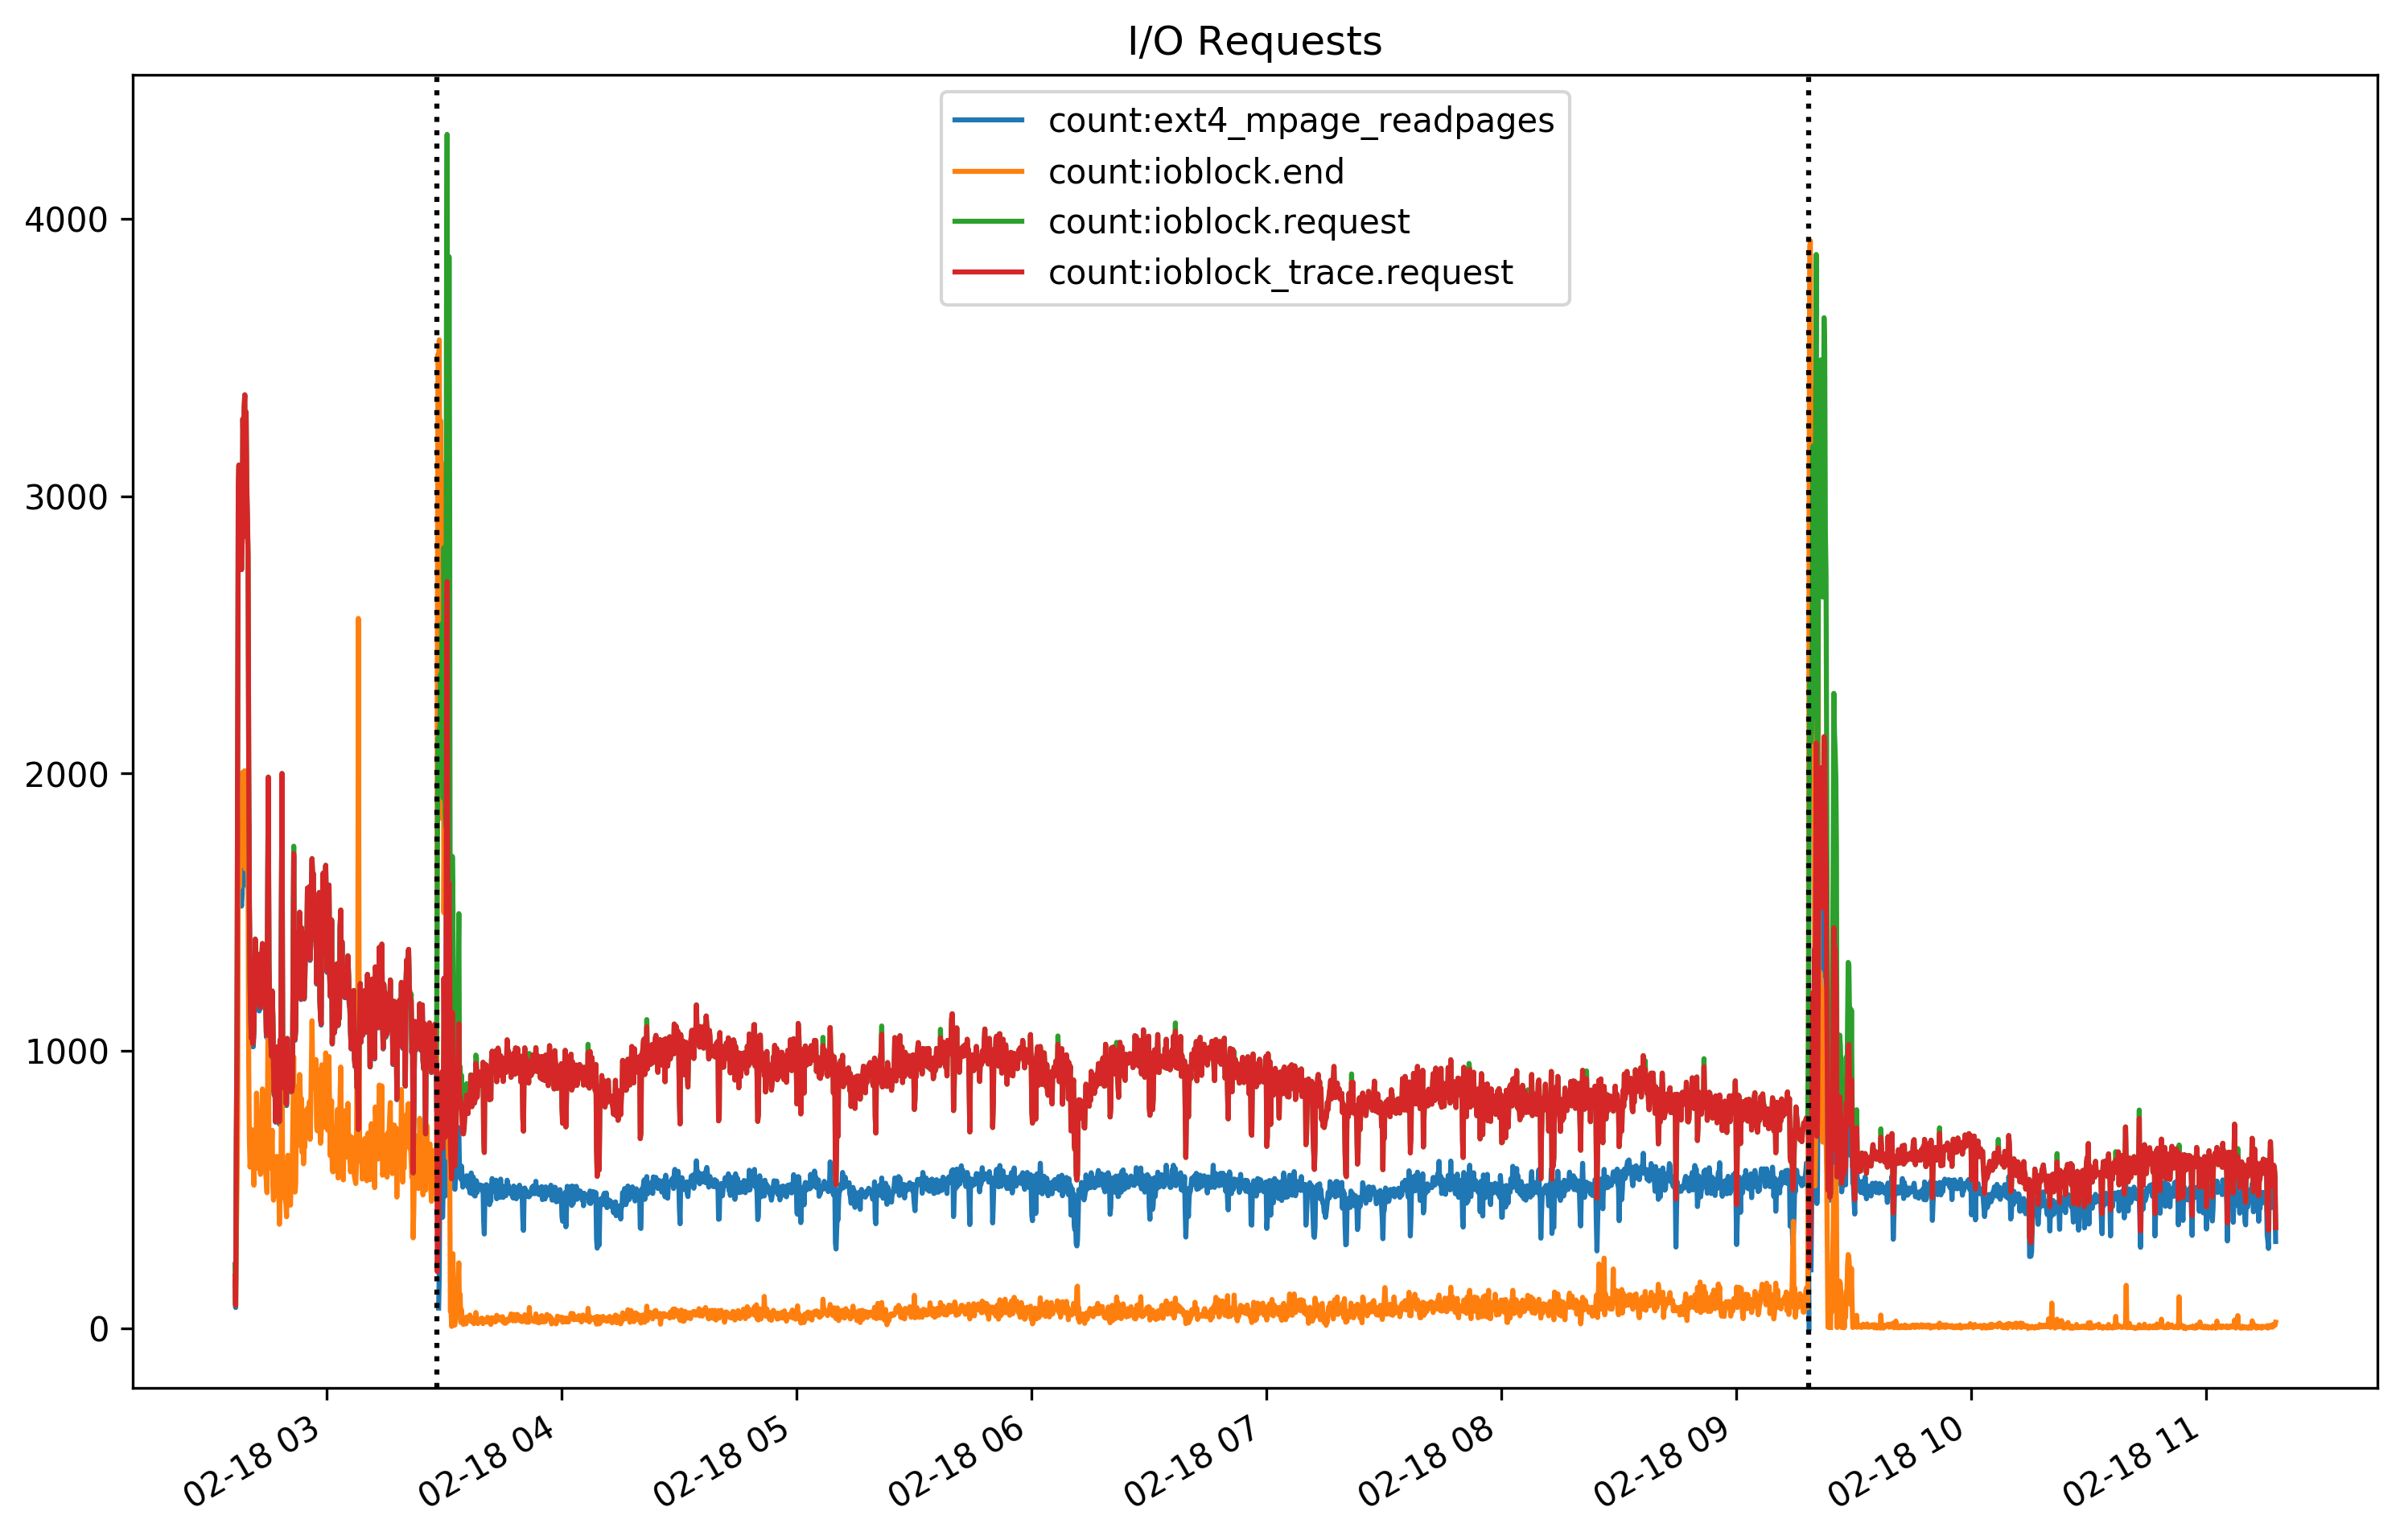

In [35]:
counts = [c for c in bio.columns if c.startswith('count:')]
plot(bio[counts], title='I/O Requests')

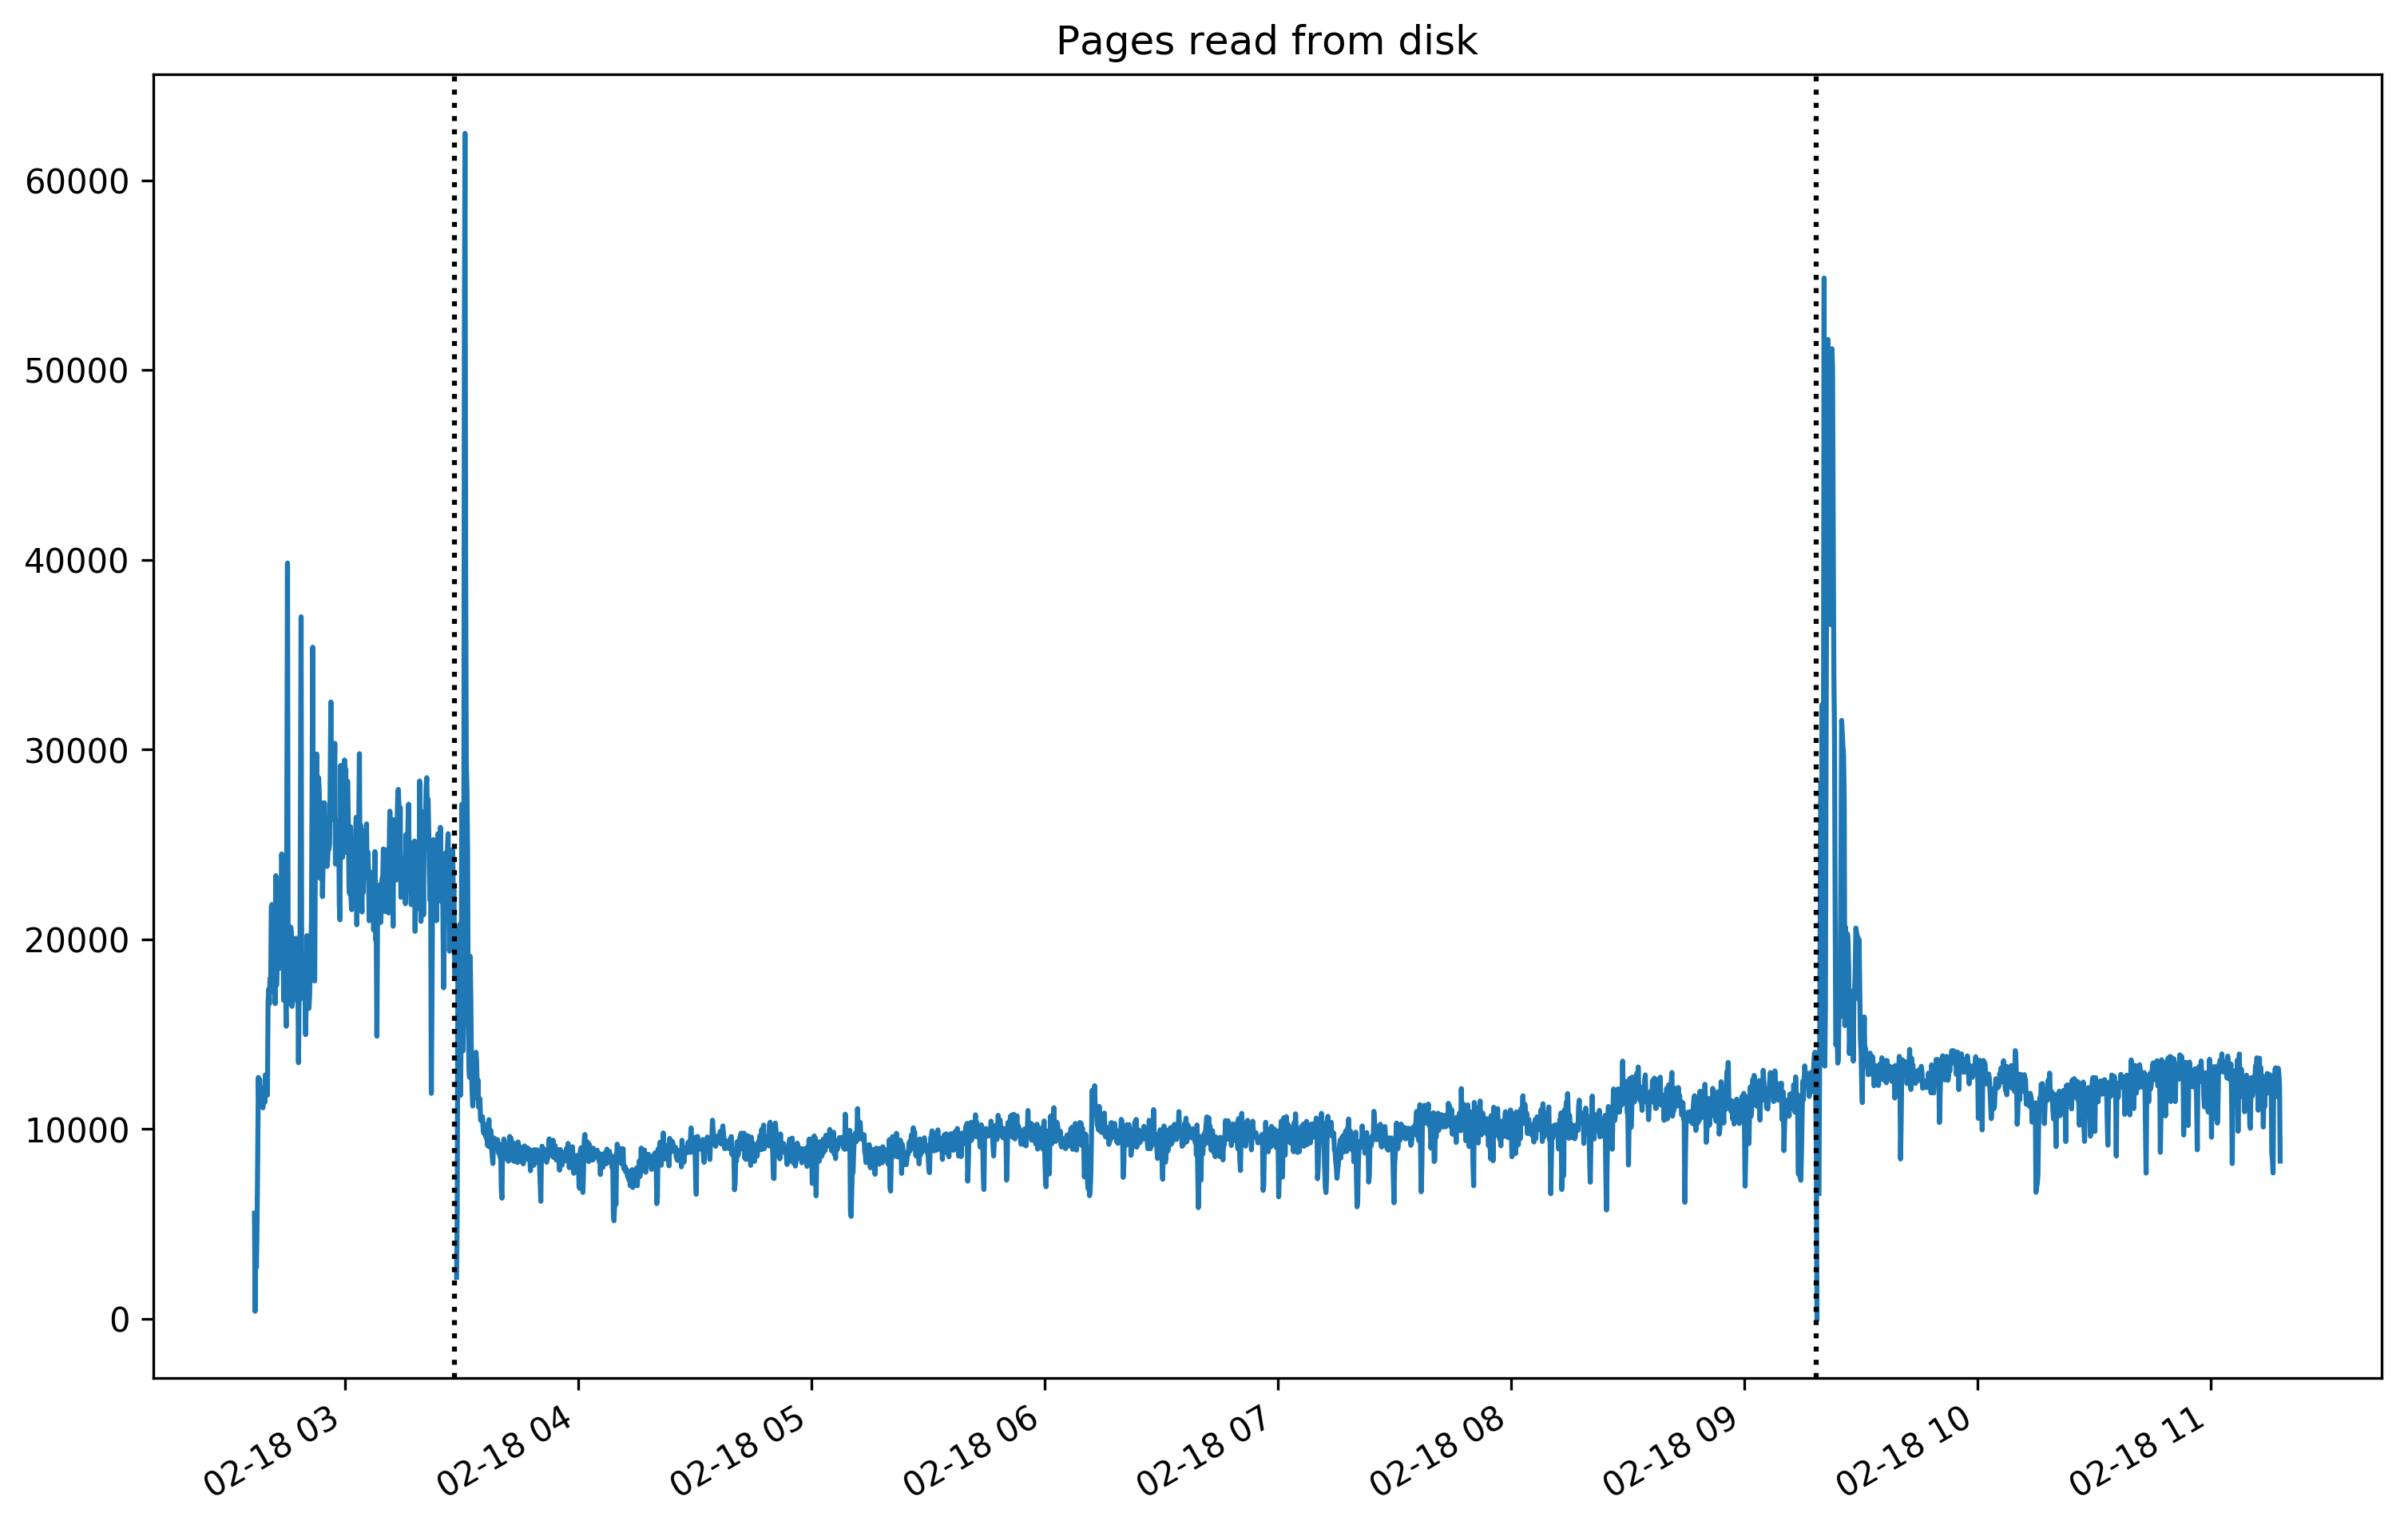

In [36]:
plot(bio['pages:ext4_mpage_readpages'], title='Pages read from disk')

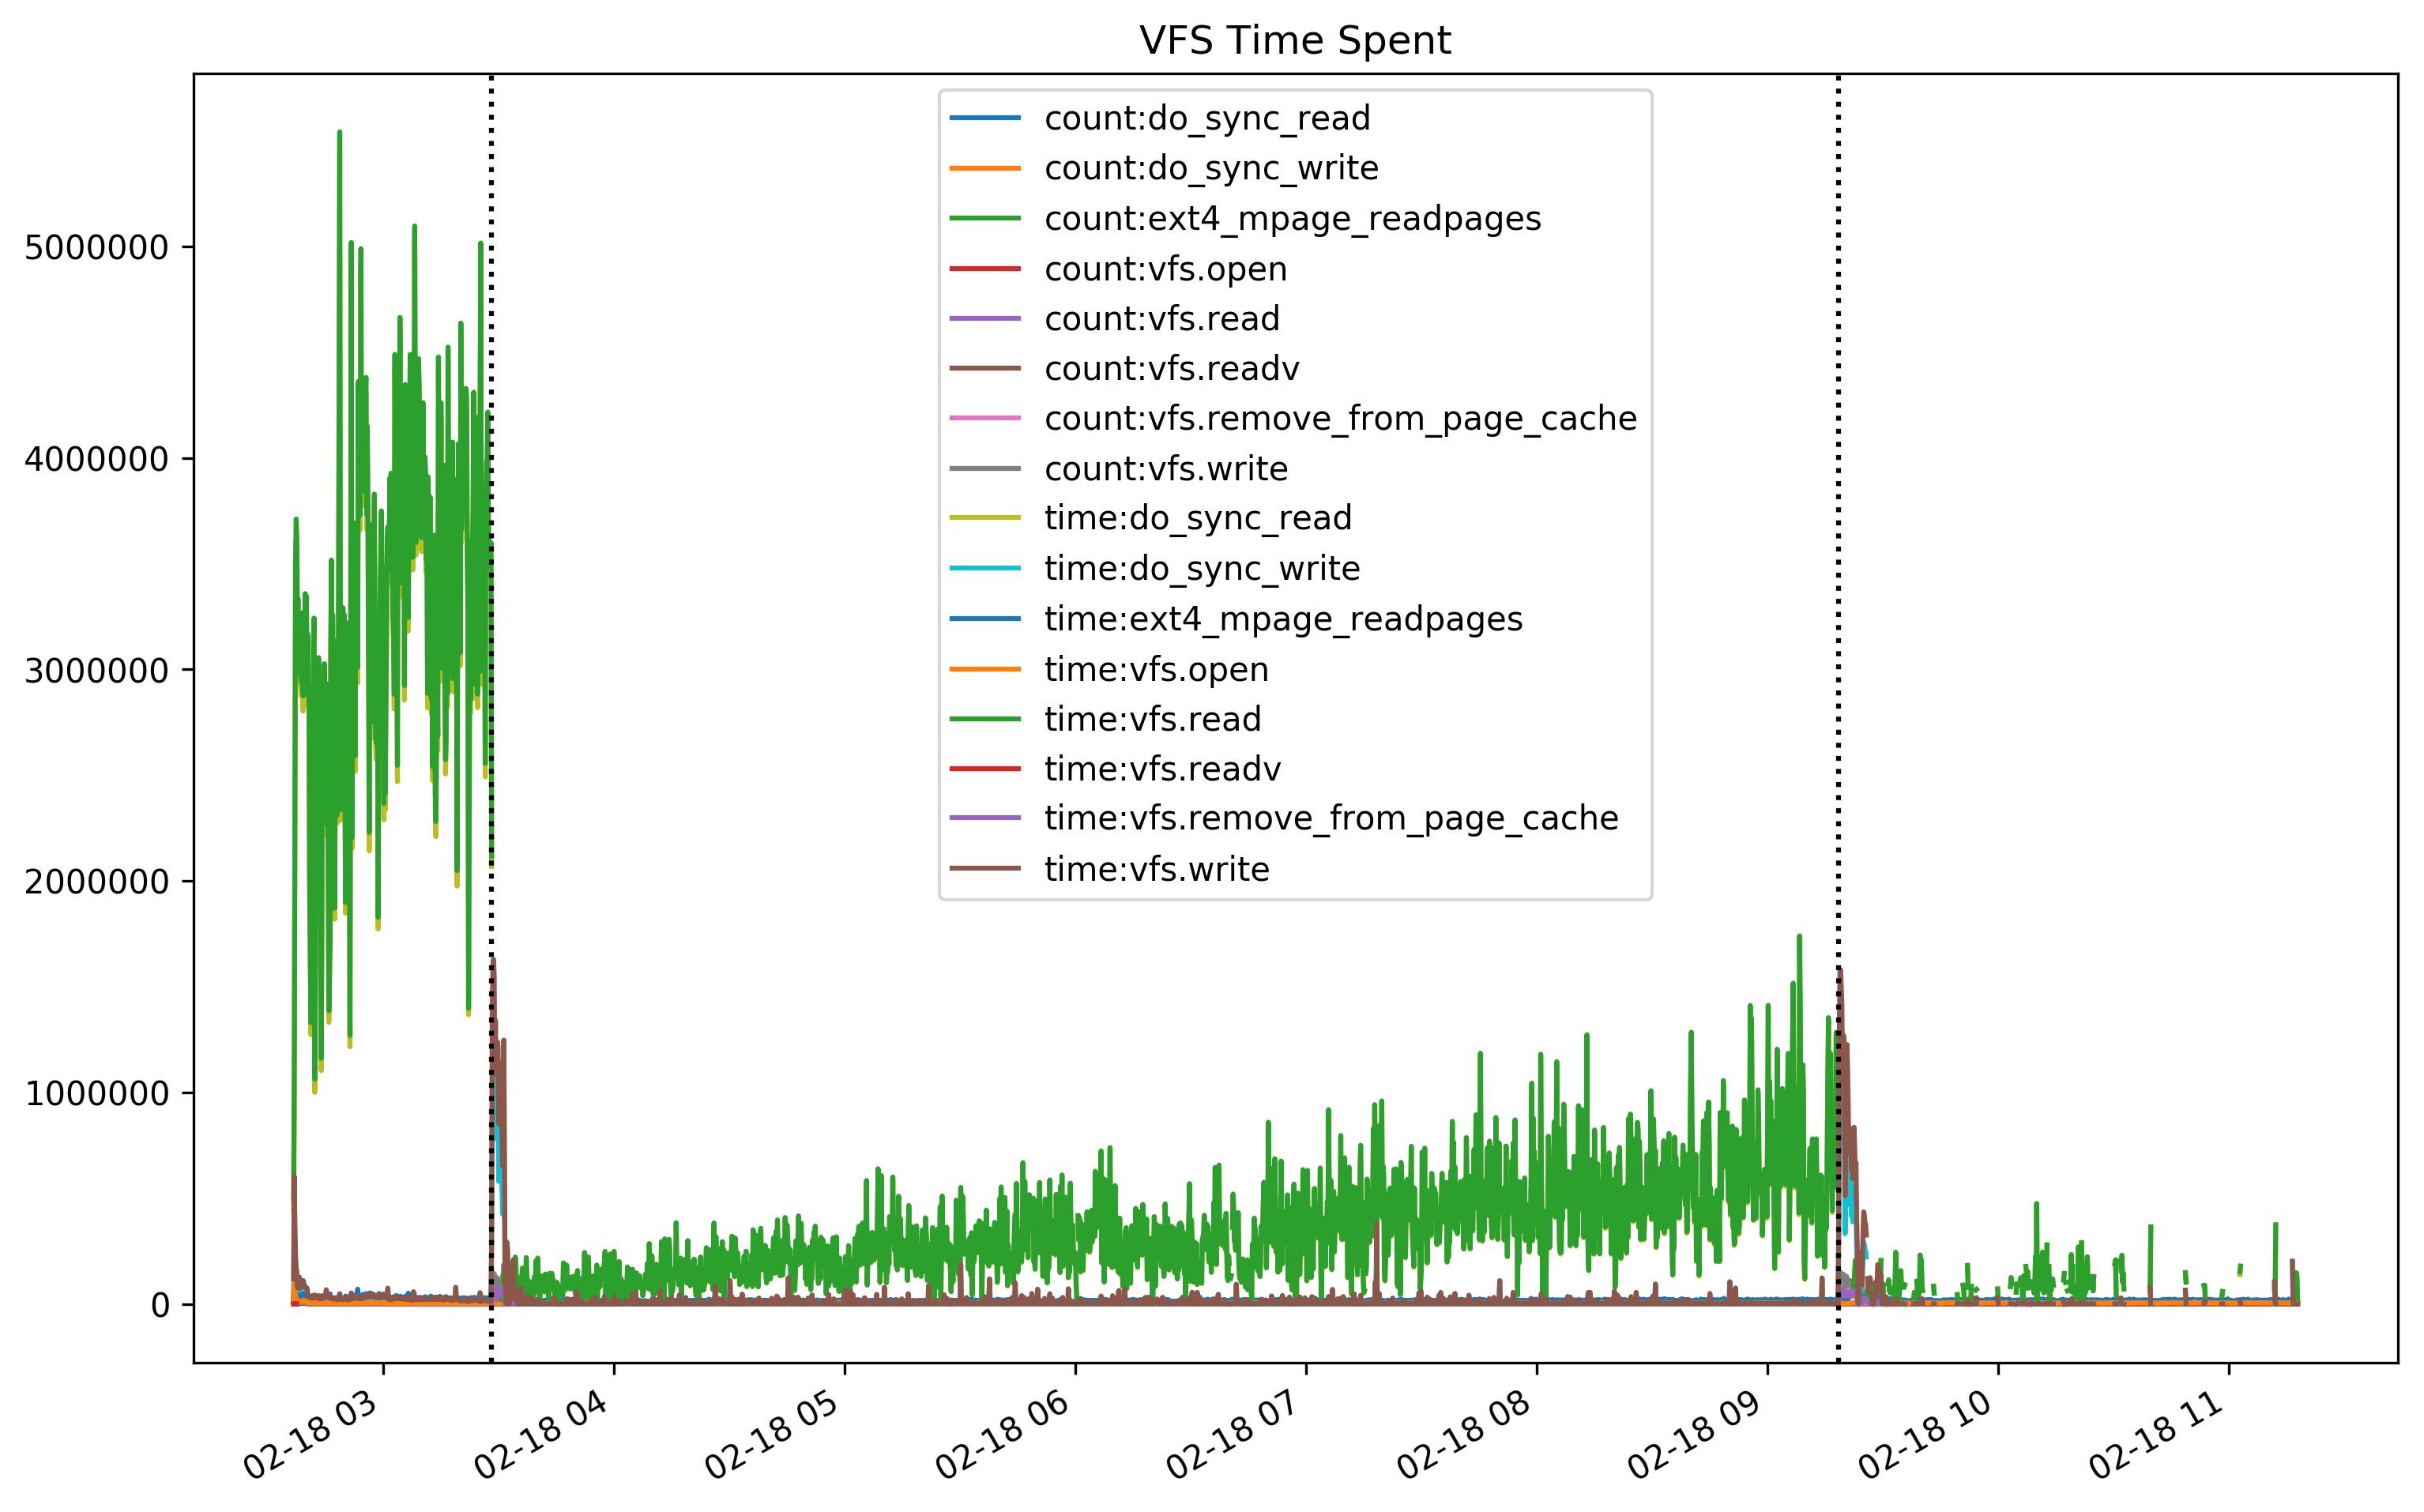

In [37]:
times = [c for c in vfs.columns if c.startswith('time:')]
plot(vfs, title="VFS Time Spent")

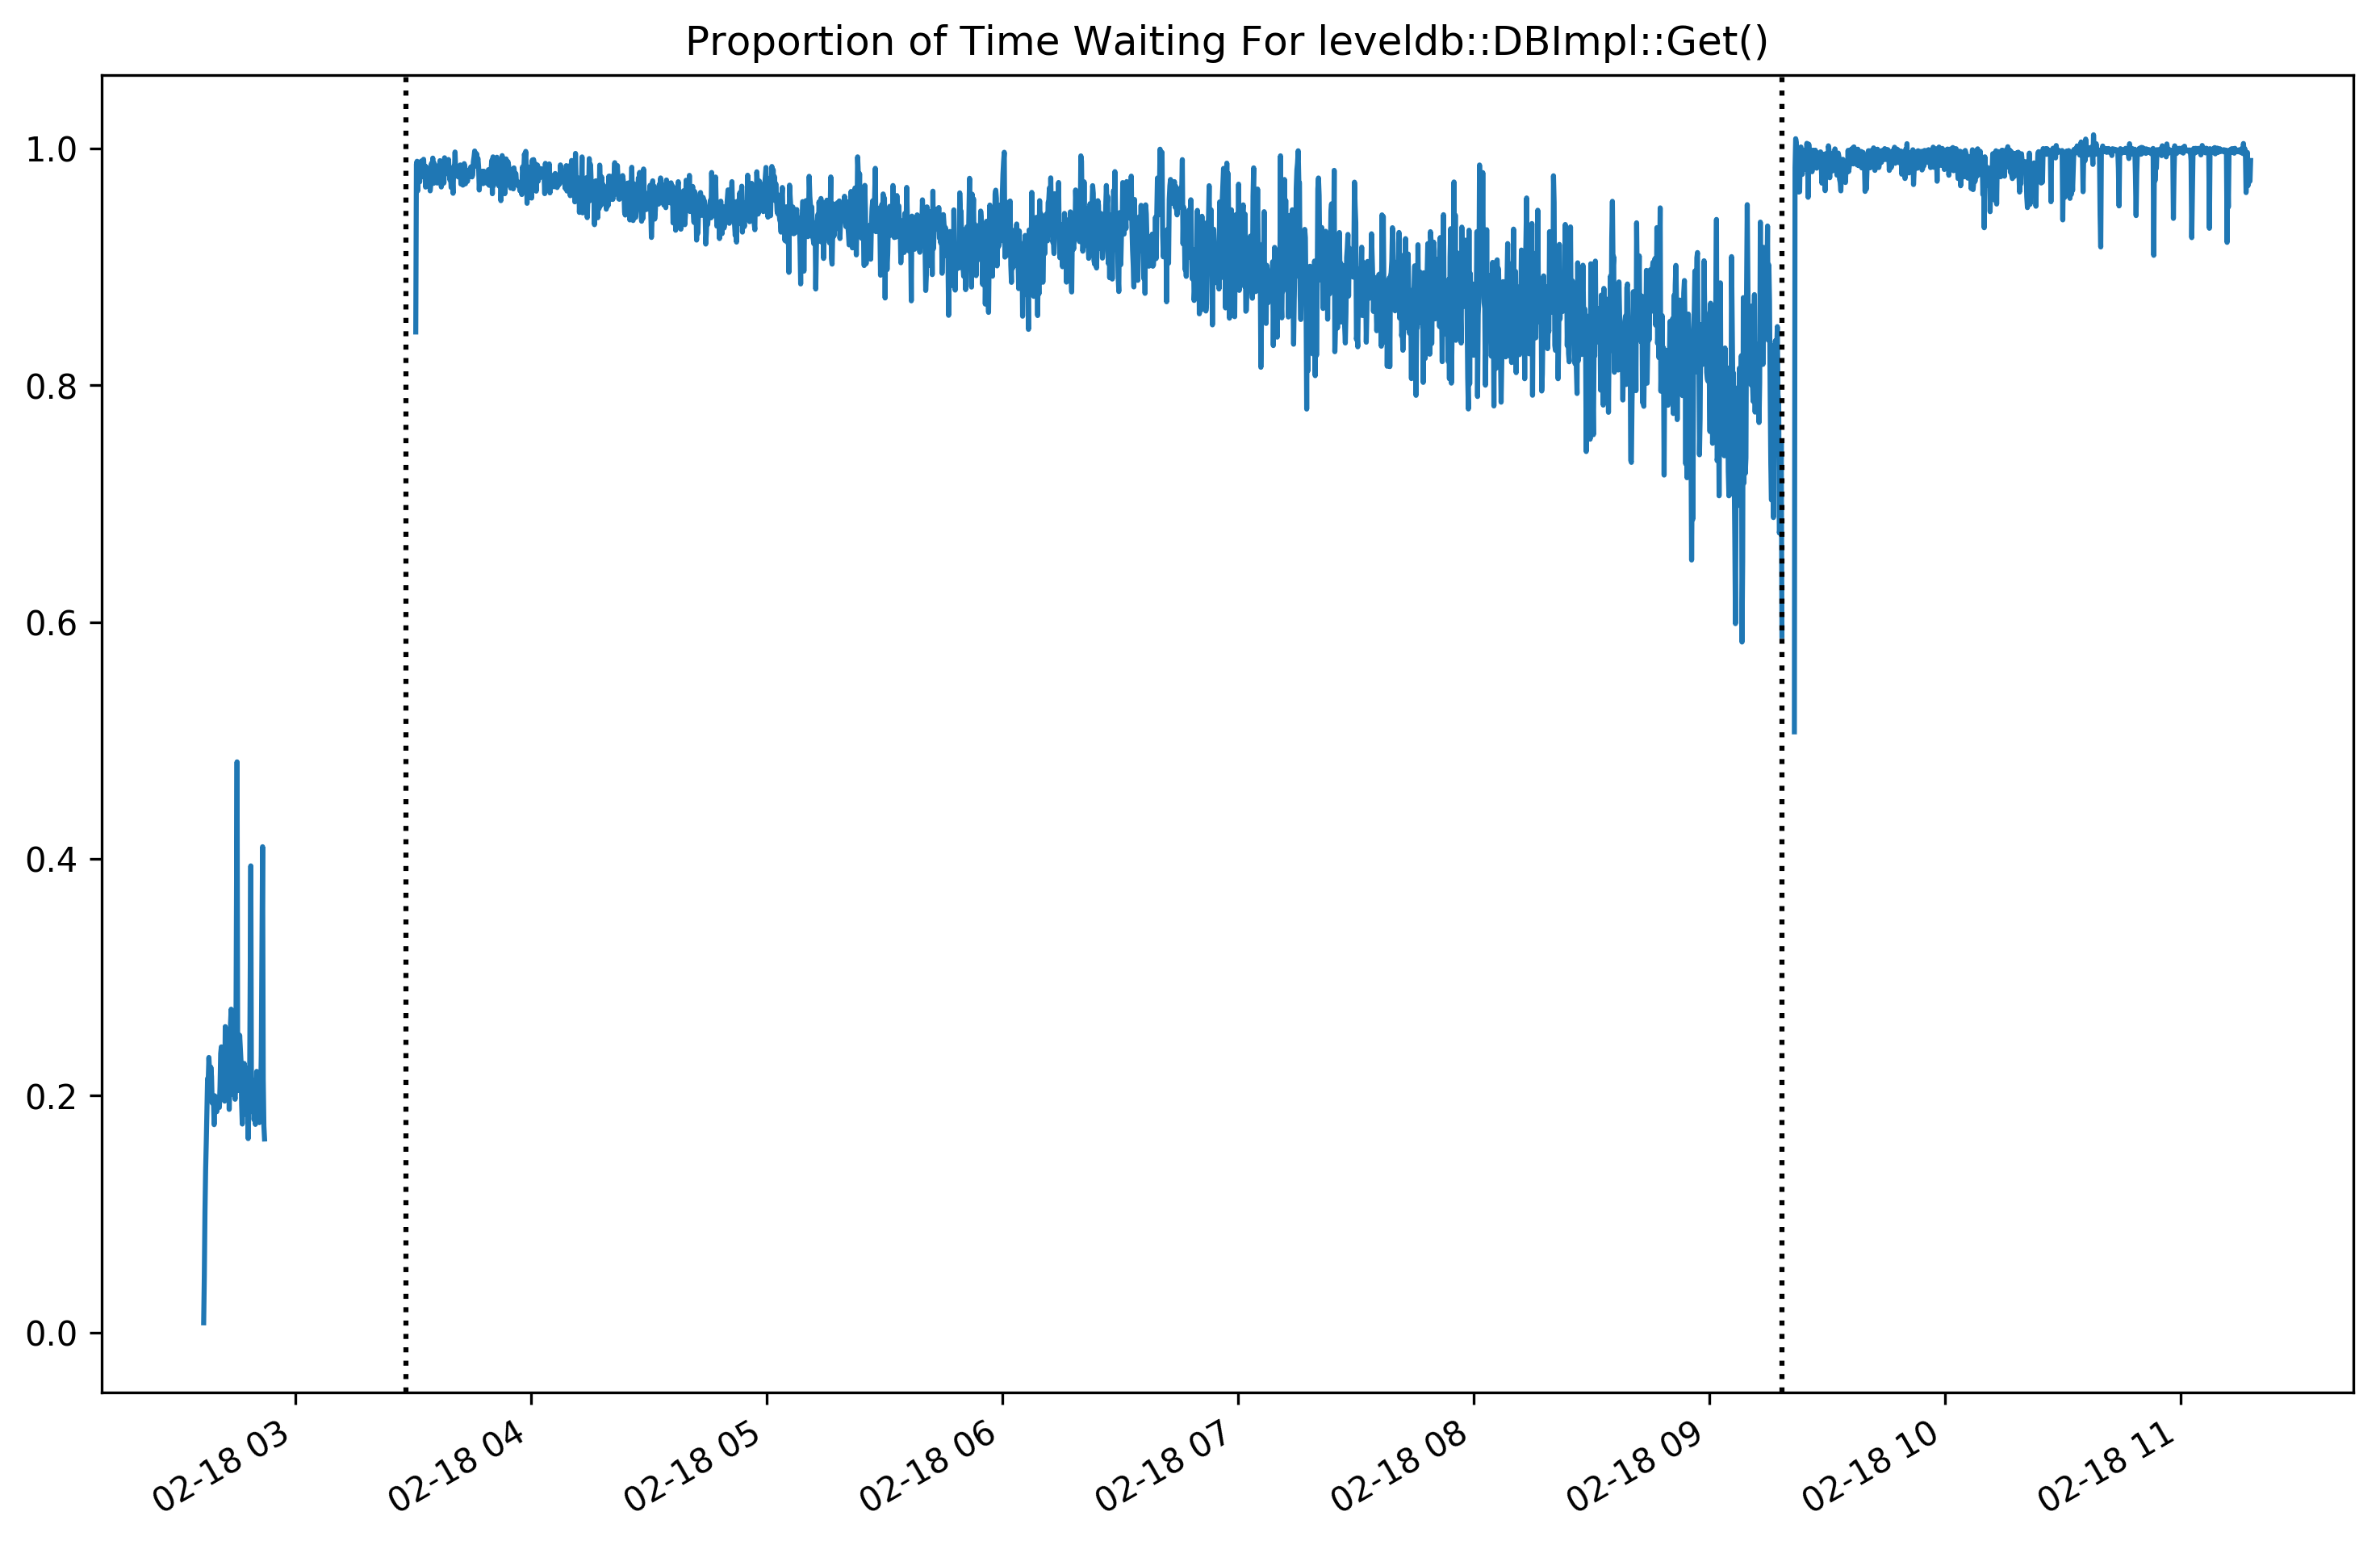

In [38]:
plot(leveldb['time:get']/1e7, title='Proportion of Time Waiting For leveldb::DBImpl::Get()')

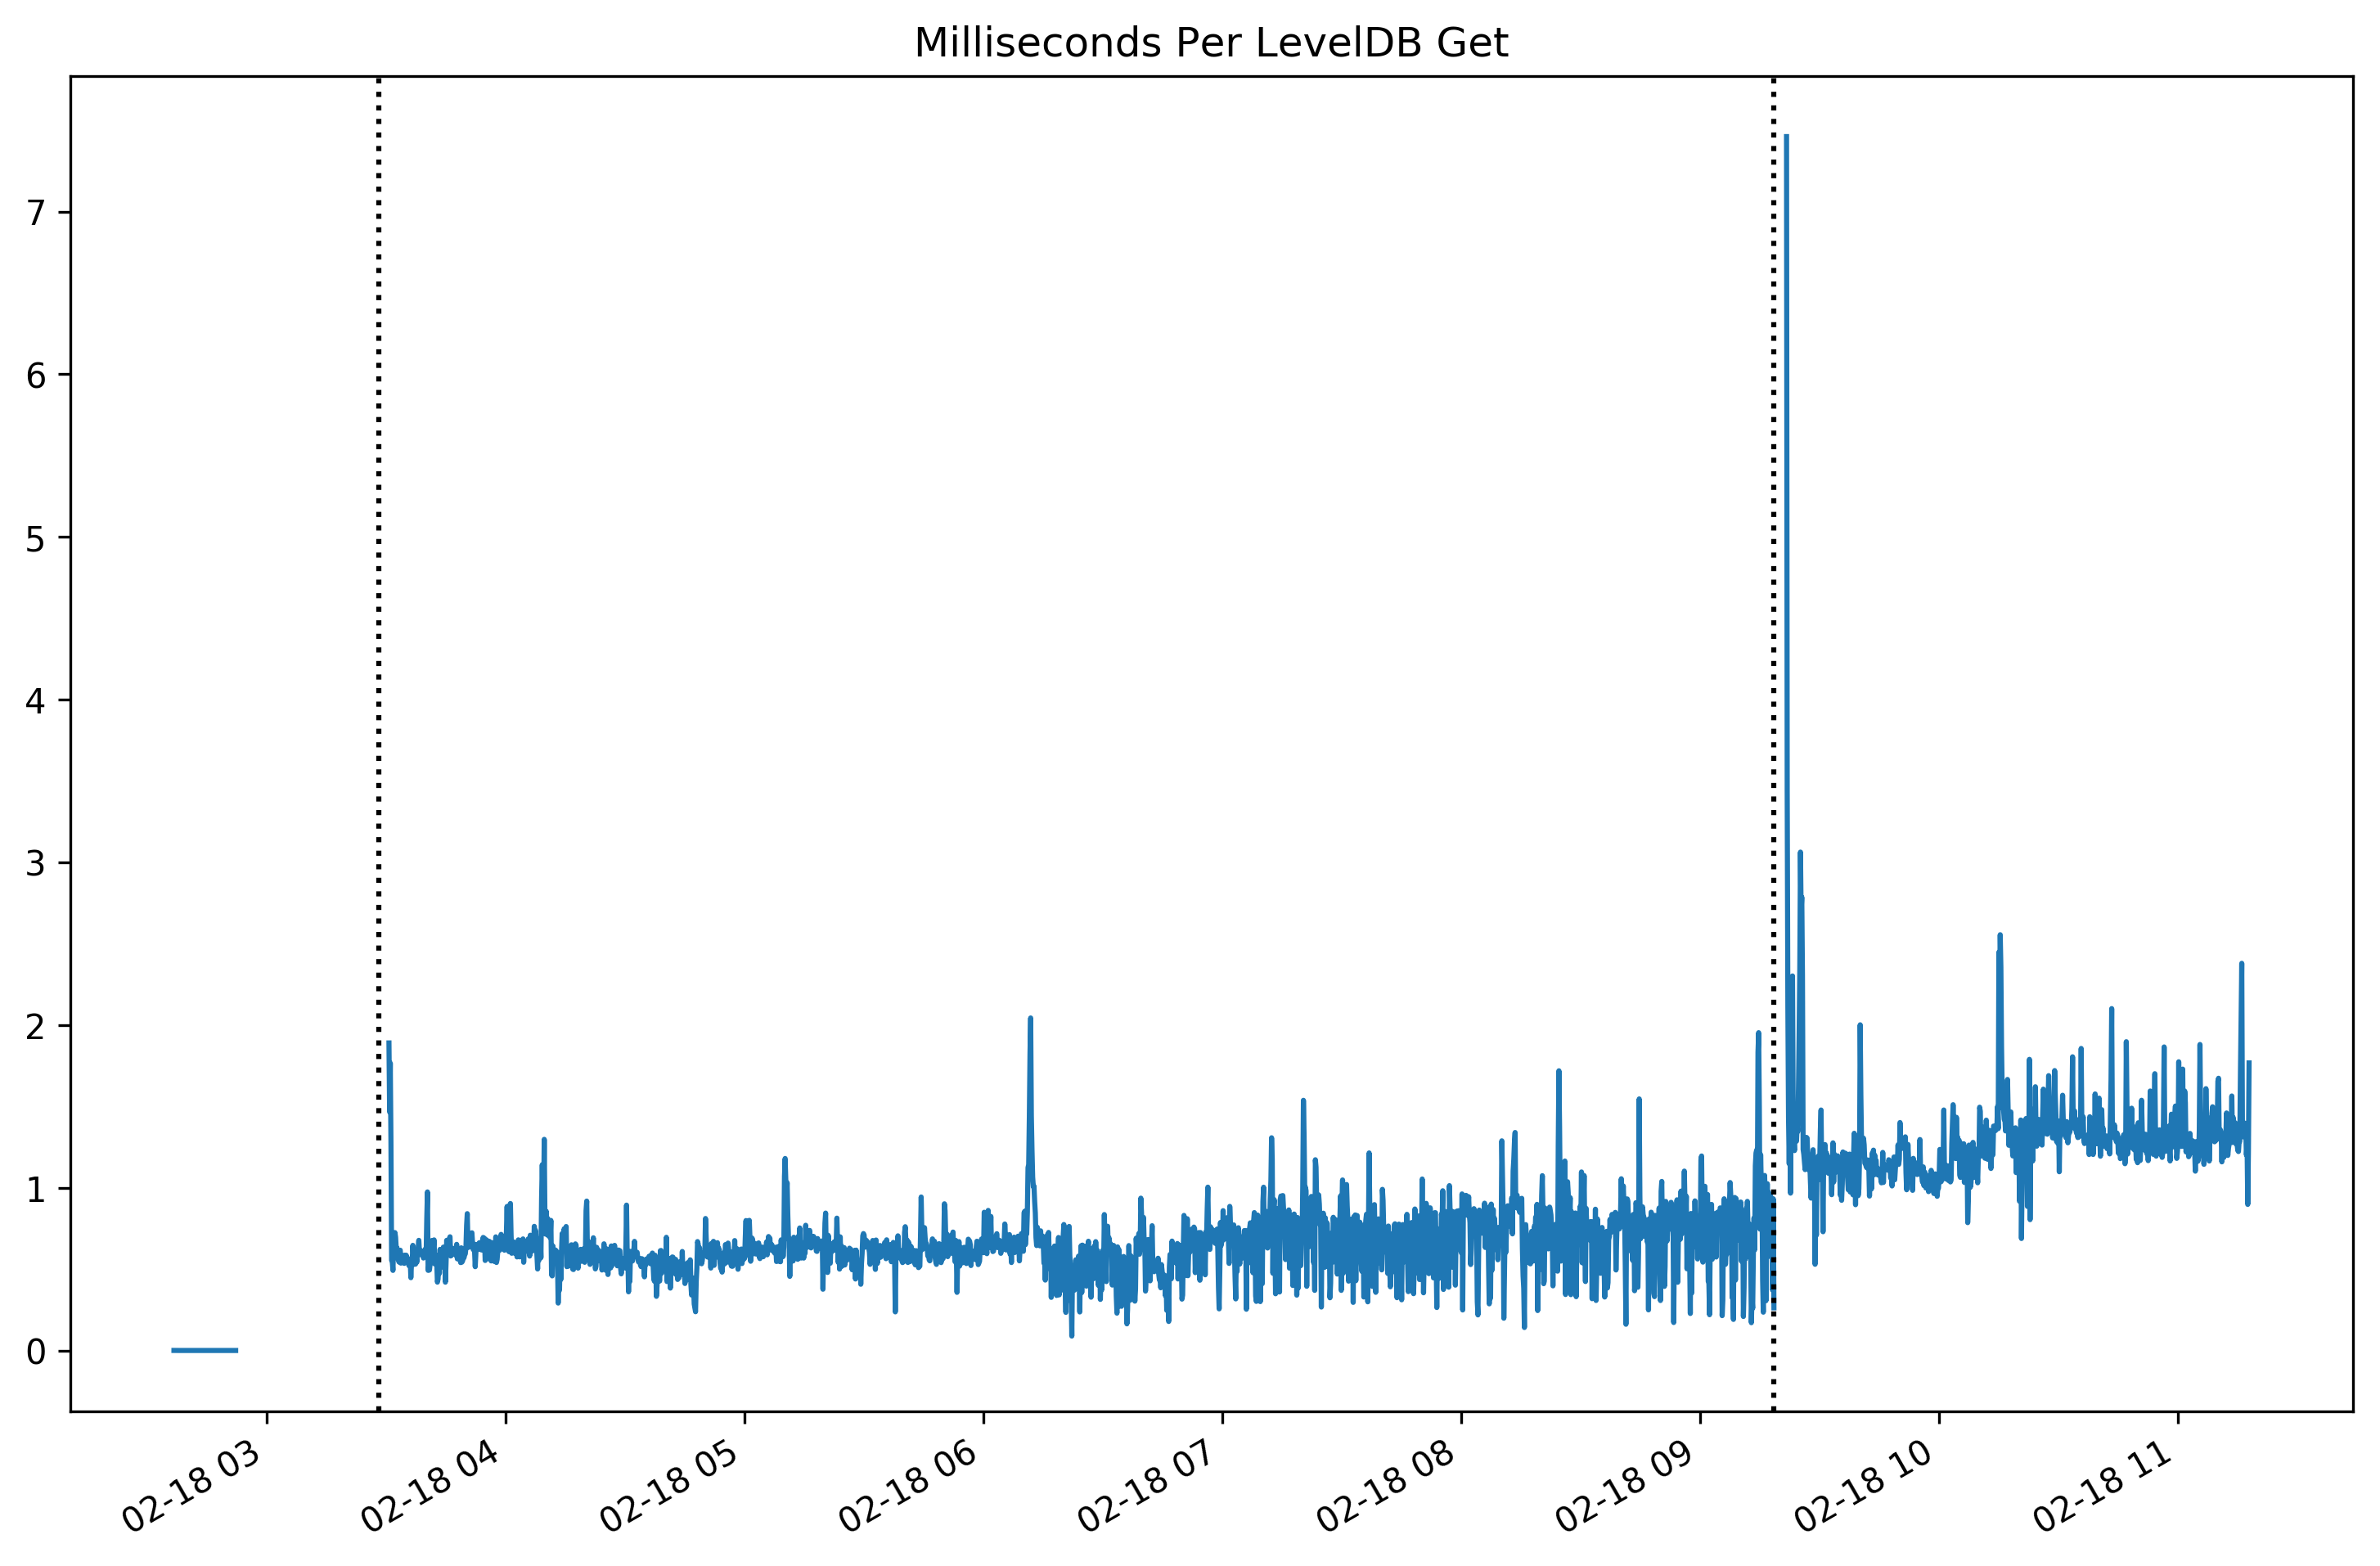

In [39]:
plot(leveldb['time:get']/leveldb['count:get']/10000, title='Milliseconds Per LevelDB Get')